In [68]:
using StatsBase
using Combinatorics
using Plots
using Optim
using LineSearches
using Statistics

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

In [90]:
function estimateParameters(H, Z, Ω, α0)
    """
    Currently assumes that the parameter vector has 2*kmax entries, and that the first and second halves of the parameter vector mean meaningfully different things. 
    """
    
    ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

    C       = evalCuts(Z,H)
    V, μ, S = evalSums(Z,H,ℓ,true);

    α = α0
    kmax = length(α)÷2
    
    res = 0
    
    function objective(α)
        obj = 0.0
        for p in keys(S)
            Op   = Ω(p; α=α, mode="partition")
            obj += C[p]*log(Op) - S[p]*Op
        end
        return -Float64(obj, RoundDown) # sign is for minimization
    end

    function objective(α, a, k)
        α_ = copy(α)
        α_[k] = a[1]
        return objective(α_)
    end
    
    α = α0
    
    for i = 1:50
        # optimization in γ
        for k = (kmax+1):(2*kmax)
            res = optimize(a -> objective(α, a, k), -3.0, 3.0) # very slow and simple -- no gradient information
            α[k] = Optim.minimizer(res)[1]

        end
        for k = 1:kmax
            res = optimize(a -> objective(α, a, k), 0, 100)
            α[k] = Optim.minimizer(res)[1]
        end
#         println(-Optim.minimum(res))
    end
    
    return α, -Optim.minimum(res)
end

estimateParameters (generic function with 1 method)

In [91]:
function plot_parameters(dataset, kmax_)

#     dataset = "TrivagoClickout"

    H, Z = read_hypergraph_data(dataset,kmax_)

    kmax = maximum(keys(H.E))
    kmin = minimum(keys(H.E))
    K = 1:kmax
        
    α0 = vcat(rand(kmax),  1.0 .+ rand(kmax));
    n = 1*length(H.D)

    function ω(p, α)
        k = sum(p)
        return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
    end

    Ω = buildΩ(ω, α0, kmax)
    
    α, ll = estimateParameters(H, Z, Ω, α0)
    
    β = α[1:kmax]
    γ = α[(kmax+1):(2*kmax)]

    lower_lim = maximum([kmin, 2])

    l = @layout [a ; b]
    p1 = plot(lower_lim:kmax, β[lower_lim:kmax], seriestype = :scatter, label = "", title = dataset)
    ylabel!("β")
    ylims!((0, 1.1*maximum(β[lower_lim:kmax])))
    p2 = plot(lower_lim:kmax, γ[lower_lim:kmax], seriestype = :scatter, label = "", color = "orange")
    ylabel!("γ")
    ylims!((0, 2))
    xlabel!("k")
    p = plot(p1, p2, layout = l)
    return p
end

plot_parameters (generic function with 1 method)

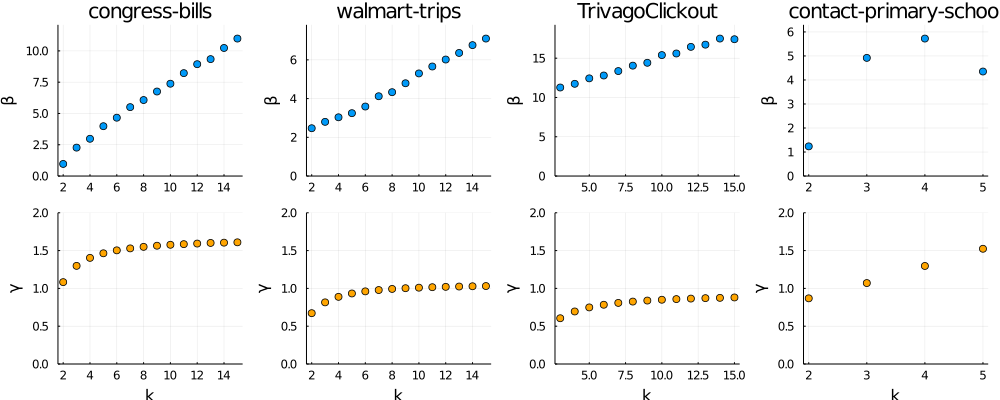

In [92]:
kmax = 15

p1 = plot_parameters("congress-bills",         kmax)
p2 = plot_parameters("walmart-trips",          kmax)
p3 = plot_parameters("TrivagoClickout",        kmax)
p4 = plot_parameters("contact-primary-school", kmax)

l = @layout [a b c d]
plot(p1, p2,p3, p4, layout = l, size = (1000, 400))

In [85]:
function plot_descriptives(dataset, kmax_)
    H, Z = read_hypergraph_data(dataset,kmax_)

    kmax = maximum(keys(H.E))
    kmin = minimum(keys(H.E))
    
    sizes = [length(H.E[k]) for k in kmin:kmax]
    
    p1 = plot(collect(kmin:kmax), sizes, seriestype = :scatter, label = "", title = dataset)
    ylabel!("# of edges")
    
    m = repeat([1.0], kmax-kmin+1)
    v = repeat([1.0], kmax-kmin+1)
    for k in kmin:kmax
        if haskey(H.E, k)
            m[k-kmin+1] = sum(partitionize(Z[e])[1]/k*H.E[k][e] for e in keys(H.E[k])) / sum(values(H.E[k]))
            v[k-kmin+1] = sqrt(var(partitionize(Z[e])[1]/k*H.E[k][e] for e in keys(H.E[k])))
        end
    end

    p2 = plot(collect(kmin:kmax), m, seriestype = :scatter, label = "", color = "orange")
    xlabel!("k")
    ylabel!("Plurality density")
    ylims!(0, 1.1)
    
    p3 = plot(collect(kmin:kmax), v, seriestype = :scatter, label = "", color = "purple")
    xlabel!("k")
    ylabel!("Plurality standard deviation")
    
    l = @layout [a ; b ; c]
    p = plot(p1, p2, p3, layout = l)
end

plot_descriptives (generic function with 1 method)

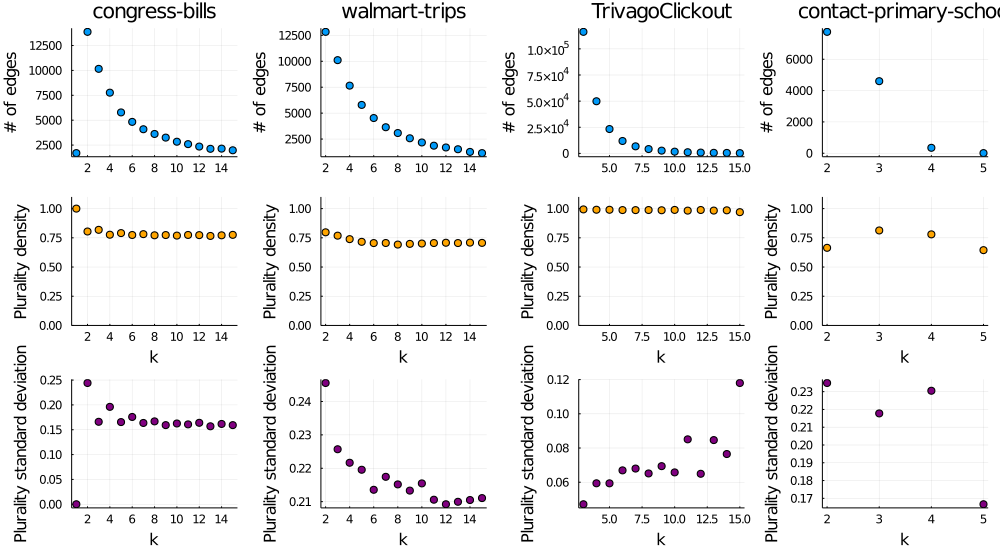

In [86]:
p1 = plot_descriptives("congress-bills",         kmax)
p2 = plot_descriptives("walmart-trips",          kmax)
p3 = plot_descriptives("TrivagoClickout",        kmax)
p4 = plot_descriptives("contact-primary-school", kmax)

l = @layout [a b c d]
plot(p1, p2,p3, p4, layout = l, size = (1000, 550))